In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from nc_time_axis import CFTimeFormatter

from fme_diags.utils import get_run_kwargs, load_config, open_autoregressive_inference
from fme_diags.hovmoller import (
    compute_daily_anomalies, remove_rolling_mean,
    plot_hovmoller_by_lon,
)
from fme_diags.tropics.MJO_E3SM_util import get_MJO_signal
    
_ = xr.set_options(keep_attrs=True)

plt.rcParams['text.usetex'] = True

In [2]:
FULL_RETRAINING = "42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema"
ZERO_SHOT =  "fv3gfs_zero_shot-run01"

RUNS =  [FULL_RETRAINING, ZERO_SHOT]

In [3]:
config = load_config("./preds.yaml")
run_kwargs_dict = {
    run: get_run_kwargs(config, run)
    for run in RUNS
}

LAT_SLICE = slice(-15, 15)

# plot final year of inference
TIME_INDEX_SLICE = slice(3285, None)

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"

In [4]:
OUTDIR = "figs/2024-05-03-hovmoller"
os.makedirs(OUTDIR, exist_ok=True)

In [5]:
ds_dict = {
    run: open_autoregressive_inference(**run_kwargs)
    for run, run_kwargs in run_kwargs_dict.items()
}

In [6]:
da_hov = {}

for key, ds in ds_dict.items():
    da = ds['surface_precipitation_rate'].isel(sample=0) * PRECIP_FACTOR
    da.attrs["units"] = PRECIP_UNITS
    
    if key == ZERO_SHOT:
        da = da.sel(source="prediction")
        
    with ProgressBar():
        da = da.sel(lat=LAT_SLICE).resample(time="1D").mean("time").compute()
        
    if key == ZERO_SHOT:
        da = da.sel(lat=LAT_SLICE).mean("lat").rename({"init_time": "init"})
        da_hov["zero_shot"] = get_MJO_signal(da)
    else:
        da_pred = da.sel(source="prediction", lat=LAT_SLICE).mean("lat")
        da_tar = da.sel(source="target", lat=LAT_SLICE).mean("lat")
        da_hov["prediction"] = get_MJO_signal(da_pred)
        da_hov["target"] = get_MJO_signal(da_tar)
        
labels = {
    "zero_shot": "ACE-FV3GFS",
    "prediction": "ACE-EAMv2",
    "target": "EAMv2",
}
    
da_hov = xr.concat(
    list(da_hov.values()),
    dim="source",
).assign_coords({"source": list(da_hov.keys())}).assign_attrs(units=PRECIP_UNITS)

da_hov

[########################################] | 100% Completed | 39.5s
[########################################] | 100% Completed | 57.9s


<xarray.DataArray (source: 3, time: 3650, lon: 360)>
array([[[0.51110319, 0.51979338, 0.52846341, ..., 0.48519518,
         0.49377669, 0.50242166],
        [0.53684785, 0.5472682 , 0.55768949, ..., 0.50587192,
         0.51612282, 0.52645692],
        [0.54270282, 0.55497634, 0.56728087, ..., 0.50634197,
         0.51835939, 0.53048823],
        ...,
        [0.35002607, 0.35529924, 0.36053232, ..., 0.33425431,
         0.3394754 , 0.34474194],
        [0.41304753, 0.4190878 , 0.425089  , ..., 0.39497995,
         0.40096557, 0.40699731],
        [0.4684335 , 0.47563297, 0.4827994 , ..., 0.44692301,
         0.45405074, 0.46123001]],

       [[0.23394668, 0.24245869, 0.25064837, ..., 0.20680251,
         0.21608577, 0.22514479],
        [0.20372416, 0.21264264, 0.22132002, ..., 0.1758511 ,
         0.18529546, 0.19459745],
        [0.17908266, 0.18798145, 0.19671899, ..., 0.1517421 ,
         0.1609308 , 0.17005501],
...
        [0.32341697, 0.32821067, 0.33248473, ..., 0.30618639,
         0.31237722, 0.31813006],
        [0.2975233 , 0.3039259 , 0.3098619 , ..., 0.27581044,
         0.28343551, 0.29068324],
        [0.26645054, 0.27411492, 0.28138   , ..., 0.24137578,
         0.25004913, 0.25841806]],

       [[0.31309007, 0.30644469, 0.29954974, ..., 0.33143283,
         0.32559347, 0.31947615],
        [0.36059537, 0.35416364, 0.34740353, ..., 0.37781966,
         0.37243292, 0.3666884 ],
        [0.41214447, 0.40639942, 0.40024028, ..., 0.42680539,
         0.42235564, 0.41746607],
        ...,
        [0.21676454, 0.21130298, 0.20572531, ..., 0.23243668,
         0.22733316, 0.22210849],
        [0.23996293, 0.23392724, 0.22775227, ..., 0.25718456,
         0.25159669, 0.24585443],
        [0.27230057, 0.26582607, 0.2591668 , ..., 0.29053747,
         0.28466401, 0.27858247]]])
Coordinates:
  * time     (time) object 0054-01-01 00:00:00 ... 0063-12-31 00:00:00
    init     object 0054-01-01 00:00:00
  * source   (source) <U10 'prediction' 'target' 'zero_shot'
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    units:    mm/day

# Filter MJO signal via detrend + taper + bandpass in Fourier space 

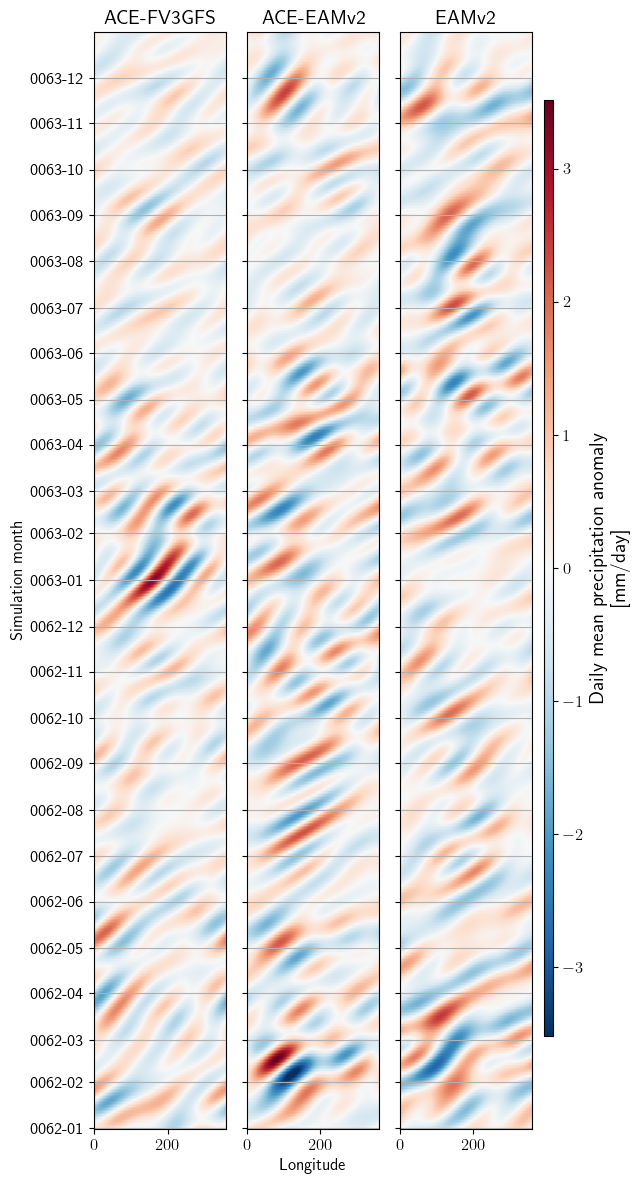

In [11]:
plt.rcParams.update({'font.size': 12})

vmax_abs = da_hov.isel(time=slice(-730, None)).max()

fig, axs = plot_hovmoller_by_lon(
    da_hov.isel(time=slice(-730, None)), 
    var_name="precipitation anomaly",
    time_label="Simulation month",
    labels=labels,
    norm=TwoSlopeNorm(0.0, -vmax_abs, vmax_abs),
    cmap="RdBu_r"
)

yticks = xr.cftime_range(
    da_hov["time"][-730].item(),
    da_hov["time"][-1].item(),
    freq="MS",
    calendar="noleap"
).values

axs[0].set_yticks(yticks)
axs[0].yaxis.set_major_formatter(CFTimeFormatter("%Y-%m", "noleap"))

for ax in axs:
    ax.grid(axis="y")

axs[0].set_xlabel("")
axs[2].set_xlabel("")

plt.show()

In [12]:
fig.savefig(os.path.join(OUTDIR, "hov-20d-100d.png"), bbox_inches="tight")